In [1]:
# conda activate fungiclef2025
# python -m ipykernel install --user --name=fungiclef2025

In [2]:
import gc
import os
import json
import yaml
from pathlib import Path
from types import SimpleNamespace
import argparse

import timm
import torch
from torchvision import transforms
from torchvision import transforms as tfms

import numpy as np
import pandas as pd
import torch
# import faiss

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import open_clip

from typing import Sequence, Tuple, Any, Dict, List, Optional, Union
import importlib

In [3]:
from datetime import datetime

datetimestr = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# path to fungitatsic dataset
data_path = Path('~/datasets/fungiclef2025/').expanduser().resolve()
# data_path = '/kaggle/input/fungi-clef-2025/'

In [6]:
class FungiTasticBEIT(torch.nn.Module):
    def __init__(self, device, image_size=384):
        super().__init__()
        self.device = device
        self.model = None
        self.processor = None
        self.image_size = image_size
        self.huggingface_id = "hf-hub:BVRA/beit_base_patch16_384.in1k_ft_df24_384"
        self.mean = [0.5, 0.5, 0.5]
        self.std = [0.5, 0.5, 0.5]
        
    def load(self):
        """
        Load the model and its associated image processor.
        """

        self.model = timm.create_model(self.huggingface_id, img_size=384, pretrained=True)
        # self.model = CustomModel(model)
        self.model.to(self.device)
        self.model.eval()        
        self.preprocess = transforms.Compose([
            transforms.Resize(int(self.image_size * 1.14), interpolation=Image.BICUBIC),
            transforms.CenterCrop(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
        ])
        # self.preprocess = transforms.Compose([
        # transforms.Resize(self.image_size),
        # transforms.CenterCrop(self.image_size),
        # transforms.ToTensor(),
        # transforms.Normalize(self.mean, self.std),
        # ])
        
    def extract_features(self, image):
        """
        Extract normalized feature embeddings from a given image.
        """
        if self.model is None:
            raise ValueError('Model not loaded')
        
        image_tensor = [self.preprocess(img).to(self.device) for img in image]
        image_tensor = torch.stack(image_tensor).squeeze()
        
        with torch.no_grad():
            # features = self.model(image_tensor)
            features = self.model.forward_features(image_tensor)
            features = self.model.forward_head(features, pre_logits=True)
            
        return self.normalize_embedding(features)
    
    @staticmethod
    def normalize_embedding(embs):
        """
        Normalize the embedding vectors to have unit length.
        """
        return torch.nn.functional.normalize(embs.float(), dim=1, p=2)

In [7]:
class DINOv2B(torch.nn.Module):
    def __init__(self, device, model_size='b', image_size=434):
        """
        Initialize the DINOv2 feature extractor with support for higher resolution images.
        
        Args:
            device: The device to run the model on (e.g., 'cuda' or 'cpu')
            model_size: Size of the DINOv2 model ('s', 'b', 'l', or 'g')
            image_size: Size to resize images to
        """
        super().__init__()
        self.device = device
        self.model = None
        self.preprocess = None
        self.model_size = model_size
        self.image_size = image_size
        
    def load(self):
        """
        Load the DINOv2 model and its associated image transforms.
        """
        
        # Map model size to the appropriate model name
        model_name = f"dinov2_vit{self.model_size}14"  # s, b, l, g

        # https://github.com/facebookresearch/dinov2?tab=readme-ov-file
        # The embedding dimension is:
        # 384 for ViT-S.
        # 768 for ViT-B.
        # 1024 for ViT-L.
        # 1536 for ViT-g.
        
        # Load the model from torch hub
        self.model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.model.to(self.device)
        self.model.eval()
        
        # # Define preprocessing transforms with larger resize dimensions
        self.preprocess = transforms.Compose([
            transforms.Resize(int(self.image_size * 1.14), interpolation=Image.BICUBIC),  # Resize larger, then crop
            transforms.CenterCrop(self.image_size),  # Crop to exact size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    def extract_features(self, image):
        """
        Extract normalized feature embeddings from a given image.
        """
        if self.model is None:
            raise ValueError('Model not loaded')
        
        image_tensor = [self.preprocess(img).to(self.device) for img in image]
        image_tensor = torch.stack(image_tensor).squeeze()
        
        with torch.no_grad():
            features = self.model(image_tensor)
            
        return self.normalize_embedding(features)
    
    @staticmethod
    def normalize_embedding(embs):
        """
        Normalize the embedding vectors to have unit length.
        """
        return torch.nn.functional.normalize(embs.float(), dim=1, p=2)

In [8]:
class DINOv2L(torch.nn.Module):
    def __init__(self, device, model_size='l', image_size=518):
        """
        Initialize the DINOv2 feature extractor with support for higher resolution images.
        
        Args:
            device: The device to run the model on (e.g., 'cuda' or 'cpu')
            model_size: Size of the DINOv2 model ('s', 'b', 'l', or 'g')
            image_size: Size to resize images to
        """
        super().__init__()
        self.device = device
        self.model = None
        self.preprocess = None
        self.model_size = model_size
        self.image_size = image_size
        
    def load(self):
        """
        Load the DINOv2 model and its associated image transforms.
        """
        
        # Map model size to the appropriate model name
        model_name = f"dinov2_vit{self.model_size}14"  # s, b, l, g

        # https://github.com/facebookresearch/dinov2?tab=readme-ov-file
        # The embedding dimension is:
        # 384 for ViT-S.
        # 768 for ViT-B.
        # 1024 for ViT-L.
        # 1536 for ViT-g.
        
        # Load the model from torch hub
        self.model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.model.to(self.device)
        self.model.eval()
        
        # # Define preprocessing transforms with larger resize dimensions
        self.preprocess = transforms.Compose([
            transforms.Resize(int(self.image_size * 1.14), interpolation=Image.BICUBIC),  # Resize larger, then crop
            transforms.CenterCrop(self.image_size),  # Crop to exact size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
        ])
        
    def extract_features(self, image):
        """
        Extract normalized feature embeddings from a given image.
        """
        if self.model is None:
            raise ValueError('Model not loaded')
        
        image_tensor = [self.preprocess(img).to(self.device) for img in image]
        image_tensor = torch.stack(image_tensor).squeeze()
        
        with torch.no_grad():
            features = self.model(image_tensor)
            
        return self.normalize_embedding(features)
    
    @staticmethod
    def normalize_embedding(embs):
        """
        Normalize the embedding vectors to have unit length.
        """
        return torch.nn.functional.normalize(embs.float(), dim=1, p=2)

In [9]:
class SAMViTH(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
        self.model = None
        self.processor = None
        self.mean, self.std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        
    def load(self):
        """
        Load the model and its associated image processor.
        """

        self.model = timm.create_model('samvit_huge_patch16.sa1b', pretrained=True, num_classes=0)
        self.model.to(self.device)
        self.model.eval()        
        data_config = timm.data.resolve_model_data_config(self.model)
        print("SAM data config:", data_config)
        self.preprocess = timm.data.create_transform(**data_config, is_training=False)
        
    def extract_features(self, image):
        """
        Extract normalized feature embeddings from a given image.
        """
        if self.model is None:
            raise ValueError('Model not loaded')

        image_tensor = [self.preprocess(img).to(self.device) for img in image]
        image_tensor = torch.stack(image_tensor).squeeze()
        
        with torch.no_grad():
            features = self.model(image_tensor)
            
        return self.normalize_embedding(features)
    
    @staticmethod
    def normalize_embedding(embs):
        """
        Normalize the embedding vectors to have unit length.
        """
        return torch.nn.functional.normalize(embs.float(), dim=1, p=2)

In [10]:
class FungiTastic(torch.nn.Module):
    """
    Dataset class for the FewShot subset of the Danish Fungi dataset (size 300, closed-set).

    This dataset loader supports training, validation, and testing splits, and provides
    convenient access to images, class IDs, and file paths. It also supports optional
    image transformations.
    """

    SPLIT2STR = {'train': 'Train', 'val': 'Val', 'test': 'Test'}

    def __init__(self, root: str, split: str = 'val', transform=None):
        """
        Initializes the FungiTastic dataset.

        Args:
            root (str): The root directory of the dataset.
            split (str, optional): The dataset split to use. Must be one of {'train', 'val', 'test'}.
                Defaults to 'val'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        super().__init__()
        self.split = split
        self.transform = transform
        self.df = self._get_df(root, split)

        assert "image_path" in self.df
        if self.split != 'test':
            assert "category_id" in self.df
            self.n_classes = len(self.df['category_id'].unique())
            self.category_id2label = {
                k: v[0] for k, v in self.df.groupby('category_id')['species'].unique().to_dict().items()
            }
            self.label2category_id = {
                v: k for k, v in self.category_id2label.items()
            }

    def add_embeddings(self, embeddings: pd.DataFrame):
        """
        Updates the dataset instance with new embeddings.
    
        Args:
            embeddings (pd.DataFrame): A DataFrame containing 'filename', 'transformation', 
                                      and 'embedding' columns.
        """
        assert isinstance(embeddings, pd.DataFrame), "Embeddings must be a pandas DataFrame."
        assert "embedding" in embeddings.columns, "Embeddings DataFrame must have an 'embedding' column."
        assert "transformation" in embeddings.columns, "Embeddings DataFrame must have a 'transformation' column."
        
        # Merge on both filename and transformation
        self.df = pd.merge(self.df, embeddings, on=["filename"], how="left")
        
        # Make sure we have embeddings for at least the original images
        assert not self.df[self.df["transformation"] == "original"]["embedding"].isna().any(), \
            "Missing embeddings for some original images"

    def get_embeddings_for_class(self, id):
        # return the embeddings for class class_idx
        class_idxs = self.df[self.df['category_id'] == id].index
        return self.df.iloc[class_idxs]['embedding']
    
    @staticmethod
    def _get_df(data_path: str, split: str) -> pd.DataFrame:
        """
        Loads the dataset metadata as a pandas DataFrame.

        Args:
            data_path (str): The root directory where the dataset is stored.
            split (str): The dataset split to load. Must be one of {'train', 'val', 'test'}.

        Returns:
            pd.DataFrame: A DataFrame containing metadata and file paths for the split.
        """
        df_path = os.path.join(
            data_path,
            "metadata",
            "FungiTastic-FewShot",
            f"FungiTastic-FewShot-{FungiTastic.SPLIT2STR[split]}.csv"
        )
        df = pd.read_csv(df_path)
        df["image_path"] = df.filename.apply(
            lambda x: os.path.join(data_path, "FungiTastic-FewShot", split, 'fullsize', x)  # TODO: 300p to fullsize if different embedder that can handle it
        )
        return df

    def __getitem__(self, idx: int):
        """
        Retrieves a single data sample by index.
    
        Args:
            idx (int): Index of the sample to retrieve.
            ret_image (bool, optional): Whether to explicitly return the image. Defaults to False.
    
        Returns:
            tuple:
                - If embeddings exist: (image?, embedding, category_id, file_path)
                - If no embeddings: (image, category_id, file_path) (original version)
        """
        file_path = self.df["image_path"].iloc[idx].replace('FungiTastic-FewShot', 'images/FungiTastic-FewShot')
    
        if self.split != 'test':
            category_id = self.df["category_id"].iloc[idx]
        else:
            category_id = None

        image = Image.open(file_path)
    
        if self.transform:
            image = self.transform(image)
    
        # Check if embeddings exist
        if "embedding" in self.df.columns:
            emb = torch.tensor(self.df.iloc[idx]['embedding'], dtype=torch.float32).squeeze()
        else:
            emb = None  # No embeddings available
    

        return image, category_id, file_path, emb


    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.df)

    def get_class_id(self, idx: int) -> int:
        """
        Returns the class ID of a specific sample.
        """
        return self.df["category_id"].iloc[idx]

    def show_sample(self, idx: int) -> None:
        """
        Displays a sample image along with its class name and index.
        """
        image, category_id, _, _ = self.__getitem__(idx)
        class_name = self.category_id2label[category_id]

        plt.imshow(image)
        plt.title(f"Class: {class_name}; id: {idx}")
        plt.axis('off')
        plt.show()

    def get_category_idxs(self, category_id: int) -> List[int]:
        """
        Retrieves all indexes for a given category ID.
        """
        return self.df[self.df.category_id == category_id].index.tolist()

In [11]:
### Load the datasets

train_dataset = FungiTastic(root=data_path, split='train', transform=None)
val_dataset = FungiTastic(root=data_path, split='val', transform=None)
test_dataset = FungiTastic(root=data_path, split='test', transform=None)

train_dataset.df.head(5)

,eventDate,year,month,day,habitat,countryCode,scientificName,kingdom,phylum,class,...,region,district,filename,category_id,metaSubstrate,poisonous,elevation,landcover,biogeographicalRegion,image_path
0,2021-01-24,2021,1.0,24.0,Mixed woodland (with coniferous and deciduous ...,DK,Xylohypha ferruginosa (Corda) S.Hughes,Fungi,Ascomycota,Eurotiomycetes,...,Sjælland,Næstved,0-3052832307.JPG,2421,wood,0,0.0,16.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
1,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,0-3061954303.JPG,386,wood,0,0.0,17.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
2,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,1-3061954303.JPG,386,wood,0,0.0,17.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
3,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,2-3061954303.JPG,386,wood,0,0.0,17.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
4,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,3-3061954303.JPG,386,wood,0,0.0,17.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...


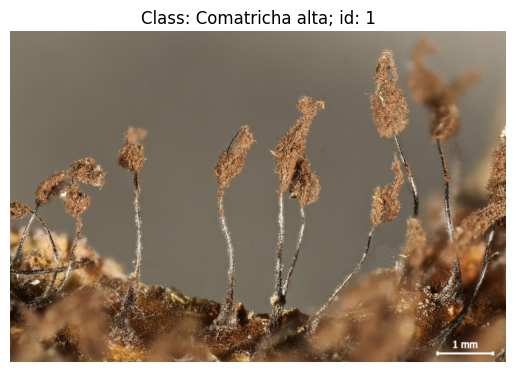

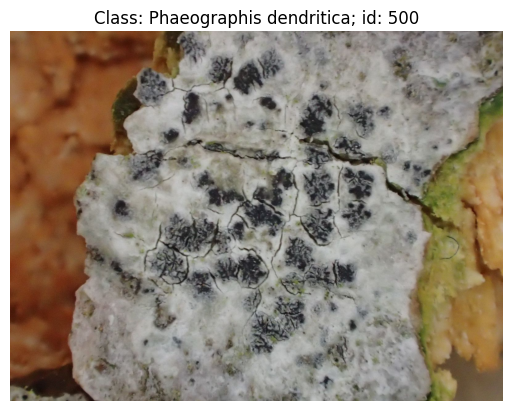

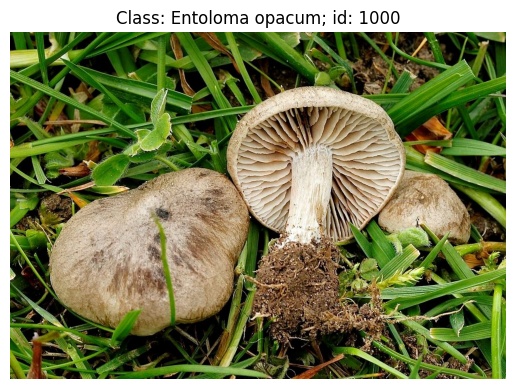

(None, None, None)

In [12]:
### Visualize few samples

train_dataset.show_sample(1), train_dataset.show_sample(500), train_dataset.show_sample(1000) 

In [13]:
import torch
import torchvision.transforms.functional as F
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import cv2

In [14]:
from PIL import Image
import os

image_dir = data_path / "images" / "FungiTastic-FewShot" / "test" / "fullsize"
val_image_dir = data_path / "images" / "FungiTastic-FewShot" / "val" / "fullsize"
train_image_dir = data_path / "images" / "FungiTastic-FewShot" / "train" / "fullsize"
image_extensions = {'.JPG'}

def show_image_details_for_dir(image_dir):
    image_sizes = []
    for filename in image_dir.iterdir():
        if filename.suffix in image_extensions:
            path = os.path.join(image_dir, filename)
            try:
                with Image.open(path) as img:
                    w, h = img.size
                    image_sizes.append((filename, w, h))
            except Exception as e:
                print(f"Failed to open {filename}: {e}")
    
    print(f"Checked {len(image_sizes)} images.")
    for fname, w, h in image_sizes[:10]:  # show a few
        print(f"{fname}: {w}x{h}")
    
    widths = [w for _, w, _ in image_sizes]
    heights = [h for _, _, h in image_sizes]
    
    print(f"Min size: {min(widths)}x{min(heights)}")
    print(f"Max size: {max(widths)}x{max(heights)}")
    print(f"Avg size: {sum(widths)//len(widths)}x{sum(heights)//len(heights)}")
    return image_sizes

train_images = show_image_details_for_dir(train_image_dir)
val_images = show_image_details_for_dir(val_image_dir)
test_images = show_image_details_for_dir(image_dir)

Checked 7819 images.
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/4-3305982302.JPG: 900x1200
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/6-2984624371.JPG: 1473x891
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/0-2901941472.JPG: 1600x1200
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/0-3329735328.JPG: 900x1200
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/1-2238467211.JPG: 800x800
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/5-3008834303.JPG: 1000x758
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/3-3305979304.JPG: 1416x966
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/1-3358358384.JPG: 1753x1200
/home/jack/datasets/fungiclef2025/images/FungiTastic-FewShot/train/fullsize/0-3068174308.JPG: 1600x1200
/home/jack/datasets/fungiclef2025/images/FungiTast

In [15]:
model_classes = {
                 "DINOv2Base@434": DINOv2B, 
                 "FungiTasticBEIT@384": FungiTasticBEIT,
                 # "DINOv2Large@518": DINOv2L,
                 # "SAMViTH@1024": SAMViTH,
                 }

models = []
for model_cls in model_classes.values():
    curr_model = model_cls(device=device)
    curr_model.load()
    curr_model.eval()
    models.append(curr_model)

def generate_embeddings(dataset):
    idxs = np.arange(len(dataset))
    data = []
    
    def original(img):
        return img
    
    def horizontal_flip(img):
        if hasattr(img, 'transpose'):  # PIL Image
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        else:  # Tensor
            return torch.flip(img, dims=[2])

    def aspect_preserving_center_crop(pil_img, scale=0.8):
        """
        Returns an aspect-preserving center crop of the input PIL image.
        The crop is `scale` times the original size (e.g., 0.8 for 80% of original).
        """
        w, h = pil_img.size
        crop_w = int(scale * w)
        crop_h = int(scale * h)
    
        left = (w - crop_w) // 2
        top = (h - crop_h) // 2
        right = left + crop_w
        bottom = top + crop_h
    
        return pil_img.crop((left, top, right, bottom))

    
    def tlcrop_no_resize(pil_img, scale=0.8):
        """
        Return four aspect-preserving corner crops, each of size
        (scale * original height, scale * original width).
        """
        w, h = pil_img.size
        crop_w = int(scale * w)
        crop_h = int(scale * h)
        box = (0, 0, crop_w, crop_h)  # Top-left
        return pil_img.crop(box)

    
    def trcrop_no_resize(pil_img, scale=0.8):
        """
        Return four aspect-preserving corner crops, each of size
        (scale * original height, scale * original width).
        """
        w, h = pil_img.size
        crop_w = int(scale * w)
        crop_h = int(scale * h)
        box = (w - crop_w, 0, w, crop_h)  # Top-right
        return pil_img.crop(box)

    
    def blcrop_no_resize(pil_img, scale=0.8):
        """
        Return four aspect-preserving corner crops, each of size
        (scale * original height, scale * original width).
        """
        w, h = pil_img.size
        crop_w = int(scale * w)
        crop_h = int(scale * h)
        box = (0, h - crop_h, crop_w, h)  # Bottom-left
        return pil_img.crop(box)

    
    def brcrop_no_resize(pil_img, scale=0.8):
        """
        Return four aspect-preserving corner crops, each of size
        (scale * original height, scale * original width).
        """
        w, h = pil_img.size
        crop_w = int(scale * w)
        crop_h = int(scale * h)
        box = (w - crop_w, h - crop_h, w, h)  # Bottom-right
        return pil_img.crop(box)

    def rot_90(img):
        return F.rotate(img, 90)
        
    def rot_180(img):
        return F.rotate(img, 180)
        
    def rot_270(img):
        return F.rotate(img, 270)
        
    def rot_15(img):
        return img.rotate(15, resample=Image.BICUBIC, expand=False)
        
    def rot_345(img):
        return img.rotate(345, resample=Image.BICUBIC, expand=False)
    
    transforms = {
        "original": original,
        "horizontal_flip": horizontal_flip,
        "rot_90": rot_90,
        "rot_270": rot_270,
        "rot_15": rot_15,
        "rot_345": rot_345,
    }

    crop_transforms = {
        "center_crop": aspect_preserving_center_crop,
        "top_left_crop": tlcrop_no_resize,
        "top_right_crop": trcrop_no_resize,
        "bottom_left_crop": blcrop_no_resize,
        "bottom_right_crop": brcrop_no_resize,
    }
    
    logged_dims = False
    for idx in tqdm(idxs):
        im, label, file_path, _ = dataset[idx]
        original_filename = dataset.df["filename"].iloc[idx]

        for transforms_dict in [transforms, crop_transforms]:  # two distinct sizes so can't be batched together
            transformed_images = []
            transform_names = []
            for transform_name, transform in transforms_dict.items():
                transformed_im = transform(im)
                if transformed_im.mode != 'RGB':
                    transformed_im = transformed_im.convert('RGB')
                transformed_images.append(transformed_im)
                transform_names.append(transform_name)

            with torch.no_grad():
                if len(models) > 1:
                    feats = []
                    emb_dims = []
                    for model in models:
                        feat = model.extract_features(transformed_images)
                        feat = feat.detach().cpu().numpy()
                        emb_dims.append(feat.shape[-1])
                        feats.append(feat)
                    feats = np.concatenate(feats, axis=1)
                
                if not logged_dims:
                    print("emb_dims:", emb_dims)
                    logged_dims = True
            
            for feats_, transform_name in zip(feats, transform_names):
                data.append({
                    'filename': original_filename,
                    'transformation': transform_name,
                    'embedding': feats_,
                    'emb_dims': emb_dims,
                })

            torch.cuda.empty_cache()
            gc.collect()
    
    embeddings = pd.DataFrame(data)
    return embeddings

Using cache found in /home/jack/.cache/torch/hub/facebookresearch_dinov2_main
/home/jack/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jack/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jack/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /home/jack/.cache/torch/hub/facebookresearch_dinov2_main


SAM data config: {'input_size': (3, 1024, 1024), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 1.0, 'crop_mode': 'center'}


In [16]:
test_dataset.df.image_path.to_numpy()[0]

'/home/jack/datasets/fungiclef2025/FungiTastic-FewShot/test/fullsize/0-4100099350.JPG'

In [17]:
test_dataset.df.head(20)

,eventDate,year,month,day,habitat,countryCode,hasCoordinate,substrate,latitude,longitude,coorUncert,observationID,region,district,filename,metaSubstrate,elevation,landcover,biogeographicalRegion,image_path
0,2023-01-08,2023.0,1.0,8.0,Deciduous woodland,DK,True,dead wood (including bark),55.993269,12.290225,50.0,4100099350,Hovedstaden,Hillerød,0-4100099350.JPG,wood,43.0,12.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
1,2023-01-10,2023.0,1.0,10.0,Unmanaged deciduous woodland,DK,True,dead wood (including bark),55.973423,10.550840,5.0,4100096393,Midtjylland,Samsø,1-4100096393.JPG,wood,64.0,12.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
2,2023-01-09,2023.0,1.0,9.0,lawn,ES,True,soil,28.501376,-17.874959,5.0,4100103428,Islas Canarias,Santa Cruz de Tenerife,0-4100103428.JPG,jord,0.0,0.0,NaN,/home/jack/datasets/fungiclef2025/FungiTastic-...
3,2023-01-09,2023.0,1.0,9.0,lawn,ES,True,soil,28.501376,-17.874959,5.0,4100103428,Islas Canarias,Santa Cruz de Tenerife,1-4100103428.JPG,jord,0.0,0.0,NaN,/home/jack/datasets/fungiclef2025/FungiTastic-...
4,2023-01-09,2023.0,1.0,9.0,lawn,ES,True,soil,28.501376,-17.874959,5.0,4100103428,Islas Canarias,Santa Cruz de Tenerife,2-4100103428.JPG,jord,0.0,0.0,NaN,/home/jack/datasets/fungiclef2025/FungiTastic-...
5,2023-01-14,2023.0,1.0,14.0,Deciduous woodland,DK,True,"stems of herbs, grass etc",55.812568,12.488360,25.0,4100096438,Hovedstaden,Rudersdal,0-4100096438.JPG,plant material,61.0,12.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
6,2023-01-28,2023.0,1.0,28.0,Bog woodland,DK,True,living leaves,55.819042,12.450128,25.0,4100102708,Hovedstaden,Rudersdal,1-4100102708.JPG,plant material,54.0,10.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
7,2023-01-27,2023.0,1.0,27.0,park/churchyard,DK,True,dead wood (including bark),55.651829,12.454617,25.0,4100103826,Hovedstaden,Brøndby,0-4100103826.JPG,wood,64.0,12.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
8,2023-02-06,2023.0,2.0,6.0,Mixed woodland (with coniferous and deciduous ...,DK,True,dead wood (including bark),55.041217,10.548573,25.0,4100096876,Syddanmark,Svendborg,2-4100096876.JPG,wood,50.0,12.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...
9,2023-02-06,2023.0,2.0,6.0,Mixed woodland (with coniferous and deciduous ...,DK,True,dead wood (including bark),55.041217,10.548573,25.0,4100096876,Syddanmark,Svendborg,3-4100096876.JPG,wood,50.0,12.0,continental,/home/jack/datasets/fungiclef2025/FungiTastic-...


In [18]:
# at least one image at fullsize is truncated

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
embeddings = generate_embeddings(test_dataset)
test_dataset.add_embeddings(embeddings)

  0%|                                                                      | 0/1911 [00:00<?, ?it/s]

emb_dims: [768, 768, 1024, 256]


  0%|▏                                                           | 4/1911 [00:13<1:45:54,  3.33s/it]

In [ ]:
test_dataset.df.head(20)

In [ ]:
embeddings = generate_embeddings(train_dataset)
train_dataset.add_embeddings(embeddings)

In [ ]:
embeddings = generate_embeddings(val_dataset)
val_dataset.add_embeddings(embeddings)

In [ ]:
# val_dataset = FungiTastic(root=data_path, split='val', transform=None)

In [ ]:
# val_dataset.df.shape

In [ ]:
exp_name = "multimodel_cache_fungiclef25"
config = {
    "exp_name": exp_name,
    "load_image_size": "fullsize",
    "models": list(model_classes.keys()),
    "augs": ["crops", "hflip", "90rotations", "15rotations"],
    "train_time_augs": [],
}

In [ ]:
from pathlib import Path
import json
    
def save_artifacts(exp_name, train_dataset, val_dataset, test_dataset, config, overwrite=False):
    file = Path(f"numpy_embed_dims_{exp_name}.npy")
    if file.exists() and not overwrite:
        raise FileExistsError("overwrite is False and artifacts exist.")
    embed_dims = test_dataset.df.emb_dims.iloc[0]
    np.save(f"numpy_embed_dims_{exp_name}.npy", embed_dims)
    train_dataset.df.to_csv(f"train_df_{exp_name}.csv", index=None)
    val_dataset.df.to_csv(f"val_df_{exp_name}.csv", index=None)
    test_dataset.df.to_csv(f"test_df_{exp_name}.csv", index=None)
    np.save(f"train_numpy_embedding_{exp_name}.npy", train_dataset.df.embedding.to_numpy())
    np.save(f"val_numpy_embedding_{exp_name}.npy", val_dataset.df.embedding.to_numpy())
    np.save(f"test_numpy_embedding_{exp_name}.npy", test_dataset.df.embedding.to_numpy())
    with open(f"config_{exp_name}.json", "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)

def load_artifacts(exp_name):
    train_df = pd.read_csv(f"train_df_{exp_name}.csv")
    val_df = pd.read_csv(f"val_df_{exp_name}.csv")
    test_df = pd.read_csv(f"test_df_{exp_name}.csv")
    embed_dims = np.load(f"numpy_embed_dims_{exp_name}.npy", allow_pickle=True)
    train_df['embed_dims'] = train_df.apply(lambda row: embed_dims, axis=1)
    val_df['embed_dims'] = val_df.apply(lambda row: embed_dims, axis=1)
    test_df['embed_dims'] = test_df.apply(lambda row: embed_dims, axis=1)
    train_embeddings = np.load(f"train_numpy_embedding_{exp_name}.npy", allow_pickle=True)
    val_embeddings = np.load(f"val_numpy_embedding_{exp_name}.npy", allow_pickle=True)
    test_embeddings = np.load(f"test_numpy_embedding_{exp_name}.npy", allow_pickle=True)
    train_df["embedding"] = train_embeddings
    val_df["embedding"] = val_embeddings
    test_df["embedding"] = test_embeddings
    return train_df, val_df, test_df

In [ ]:
save_artifacts(exp_name, train_dataset, val_dataset, test_dataset, config)

In [ ]:
# train_dataset = FungiTastic(root=data_path, split='train', transform=None)
# val_dataset = FungiTastic(root=data_path, split='val', transform=None)
# test_dataset = FungiTastic(root=data_path, split='test', transform=None)

# train_dataset.df, val_dataset.df, test_dataset.df = load_artifacts(exp_name)